In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
from scipy.integrate import cumtrapz

dpi = 300
transparent = True
PI = np.pi
TWO_PI = 2*PI
NUM = 44000
show = False

sns.set_theme('talk')
sns.set_style("whitegrid")

(sec-lti-filters)=
# LTI Filters

In the following I will discuss a special kind of filters, that is, *linear time-invariant filters* because almost all filters you will encounter in [SuperCollider](https://supercollider.github.io/) are based on this type of filters.
It is recommended that you read section [Z-transform](sec-z-transform) before continuing or that you go back and forth to understand the concept of a Z-transform.

## What is a Filter?

A digital filter refers to any electronic or digital system that enhances or reduces frequencies within a signal.
Broadly speaking, any medium that a signal traverses, regardless of its form, can be considered a filter.
However, an entity is typically not deemed a filter unless it has the ability to alter the signal in some manner.
For instance, while speaker wire is not classified as a filter, the speaker itself is, regrettably.
The production of different vowel sounds in speech mainly involves altering the shape of the oral cavity, which modifies the resonances and consequently the filtering characteristics of the vocal tract. Devices such as reverberators, echo units, phase shifters, and speaker crossover networks serve as examples of beneficial filters, whereas the uneven amplification of certain frequencies in a space with poor acoustics illustrates unwanted filtering.

A digital filter operates on digital signals specifically. It involves a computational process that converts one numerical sequence, $x[\cdot]$, into another, $y[\cdot]$.
Digital filters are capable of replicating the functions of physical filters with a high degree of accuracy.
Therefore, a digital filter represents a method for transitioning between digital signals.
It can manifest as a theoretical equation, a loop within computer software, or a series of interconnected integrated circuit chips.

## Why Learn About Filters?

Computer musicians frequently incorporate digital filters into each piece of music they produce. For instance, achieving a rich, resonant sound from a computer is challenging without the use of digital reverberation.
However, the potential of digital filters extends far beyond just reverberation.
They can precisely tailor the sound spectrum to specific needs.
Despite this, only a handful of musicians are equipped to create the filters they require, even when they have a clear vision of the desired spectral alteration.
This book aims to support sound designers by providing an overview of the most important filters implemented in [SuperCollider](https://supercollider.github.io/).

Numerous software options exist for creating digital filters, suggesting that only basic programming skills might be necessary to utilize digital filters effectively.
While this may hold true for straightforward tasks, a deeper understanding of how digital filters operate is beneficial at all stages of using such software.

Additionally, to adapt or customize a program, one must first thoroughly comprehend its workings.
Even for standard uses, proficiently applying a filter design program demands knowledge of its design parameters, which is grounded in an understanding of filter theory.
Importantly, for composers crafting their own sounds, mastering filter theory opens up a wide array of creative filtering possibilities that can significantly impact sound quality.
From my own hands-on experience, a deep grasp of filter theory has been an invaluable asset in designing musical instruments.
Often, the need arises for a simple yet unique filter, different from the conventional designs readily available through existing software.

## A Simple Filter?

If we aim to entirely filter out all high frequencies up to a cutoff frequency $f_c$, without affecting the low frequencies $(f \leq f_c)$, our ideal *brick wall filter* would exhibit an *amplitude (frequency) response* resembling the plot shown below.

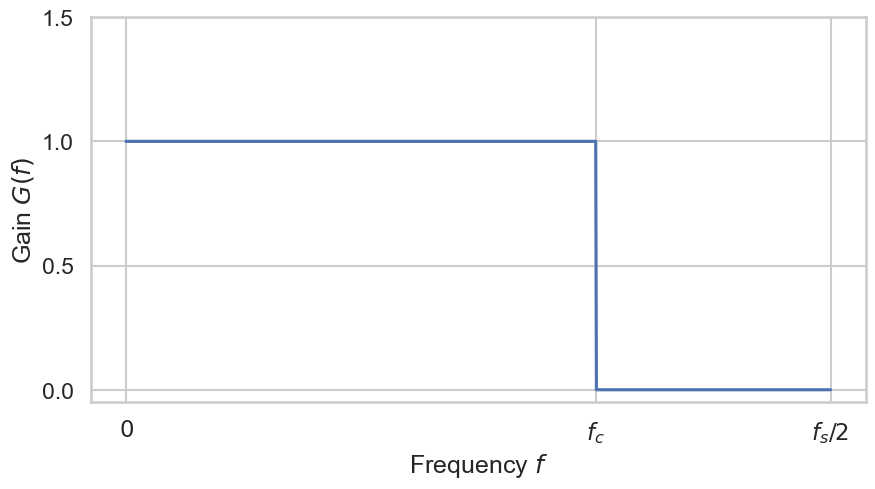

In [2]:
f_s = 3
f_c = 2
t = np.linspace(0, f_s, 1000)
gain = lambda x: 1 if x <= f_c else 0
y = [gain(val) for val in t]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, y, label=r'$y(t)$')
ax.set_xticks([0, f_c, f_s])
ax.set_xticklabels([r'$0$', r'$f_c$', r'$f_s/2$'])
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_xlabel('Frequency $f$');
ax.set_ylabel(r'Gain $G(f)$');

Such *ideal filter* is the simplest *lowpass filter*.
The gain is 1 in the *passband*, which pans frequencies from 0 Hz to the *cutoff frequency* $f_c$ Hz, and its gain is 0 in the *stopband* (all frequencies above $f_c$).
The output spectrum is obtained by multiplying the input spectrum by the amplitude response of the filter.

Another simple (and by no mean ideal) lowpass filter that we can define by a simple formula is give by the differential equation:

```{math}
:label: eq:simple:filter
y[n] = x[n] + x[n-1]
```

where $x[n]$ is the filter input amplitude at time (or sample) $n$, and $y[n]$ is the output amplitude at time $n$.
We can also draw a *signal flow graph* for this little filter:

```{figure} ../../../figs/sounddesign/math/sfg-simple-filter.png
---
width: 400px
name: fig-sfg-simple-filter
---
Signal flow graph of the diffential equation filter.
```

The $z^{-1}$ symbol means a *delay* of one sample, i.e., $z^{-1} x[n] = x[n-1]$.

It is important when working with spectra to be able to convert time from sample-numbers to seconds.
Thus, a more physical way of writing equation Eq. {eq}`eq:simple:filter` is given by

$$y[n T] = x[n T] + x[(n-1) T] \quad n = 0, 1, 2, \ldots,$$

where $T$ is the sampling interval in seconds.
It is convinient in digital signal processing to omit $T$, i.e. set $T = 1$, but anytime you see $n$ you can translate to seconds by thinking $nT$.

We can easily define such a filter in ``sclang``:

```isc
(
var simpleFilter = { |in, xm1=0|
  var out = Array.newClear(x.size);
  out[0] = in[0] + xm1;
  for(1, in.size-1, { |n|
    out[n] = in[n] + in[n-1];
  });
  out
};

x = [1,2,3,4,5,6];

// [ 1, 3, 5, 7, 9, 11 ]
y = simpleFilter.(x);
)
```

The variable ``xm1`` can be referred to as the filter's state, representing the filter's current memory at the time of invoking simplp. 
This filter is characterized as a *first-order filter* due to it having a single sample of state. 
It is essential to preserve the state of the filter after processing each segment of a signal. 
Therefore, the state of the filter following the completion of block $m$ becomes the initial state for processing the subsequent block $m+1$.

You might suspect that since Eq. {eq}`eq:simple:filter` is the simplest possible low-pass filter, it is also somehow the worst possible low-pass filter.
How bad is it? 
In what sense is it bad? 
How do we even know it is a low-pass at all? 
The answers to these and related questions will become apparent when we find the *[frequency response](sec-frequency-response)* of this filter.

In any case, we could use a input sinusoid and compute the resulting output signal.
Let 

$$x[n] = A_1 \sin(2 \pi f n T + \phi_1).$$

If we apply Eq. {eq}`eq:simple:filter`, we get

$$y[n] = A_1 \sin(2 \pi f n T + \phi_1) + A_1 \sin(2 \pi f (n+1) T + \phi_1).$$

Let us use $A_1 = 1$ and $f = f_s/4 = 1/(4T)$ and $\phi_1 = 0$.
Then the output sinusoid is given by

$$y[n] = A_2 \sin(2 \pi f n T + \phi_2)$$

with $A_2 \approx 1.414$, $f = f_s / 4$, and phase $\phi_2 = -\pi / 4$.
This tells us how one specific frequency is influenced by the filter.
The gain $G(2 \pi f) = A_2 / A_1 = A_2 \approx 1.414$.

```{admonition} Gain of a Single Frequency of an LTI Filter
:name: def-gain-lti-theorem
:class: theorem

If the input to any [LTI filter](def-linear-time-invariant) is a complex waveform $A \cdot e^{i 2\pi f t}$, the output will be some constant times the input $B \cdot e^{i 2 \pi f t}$ and $G(2 \pi f)$ is defined by

$$G(2 \pi f) = \frac{B}{A}.$$

```

What we desire is a formula that gives us the amplitude response and the phase response for all frequencies, that is, the [frequency response](sec-frequency-response) of the filter.
In the general case, this is a hard problem.
However, there are a special type of filters for which this is achievable, that is, the *[linear time-invarient filters](def-linear-time-invariant)*.

## A Special Type of Filters

*Linear filters* process time-varying input signals to produce output signals, subject to the constraint of *linearity*.
In most cases these linear filters are also *time invariant* (or *shift invariant*) in which case they can be analyzed exactly using [LTI](def-linear-time-invariant) (linear time-invariant) system theory.

```{admonition} Linear Time-invariant Filters (LTI)
:name: def-linear-time-invariant
:class: definition

Let $x[n]$ be the input signal and $y[n]$ be the output signal of a filter.
Then a filter is *linear time-invariant* if the following two conditions hold:

1. **Linearity**: $a \cdot x[n]$ translates to $a \cdot y[n]$ and $x_1[n] + x_2[n]$ translate to $y_1[n] + y_2[n]$ (superposition principle).
2. **Timeinvarianze**: whether we apply an input to the filter now or some time later does not matter. The filters effect does not change over time.

```

For example, if we modulate the cutoff frequency of a filter, it is no longer *time-invariant*.
To analyse the behaviour of a *linear filter* one looks at two different effects.

1. The **frequency response** $H$ in the frequency domain ($z$-plane): how does the amplitude and phase of a frequency $f$ changes.
2. The **impulse response** $h$ in the time domain: how does the amplitude over time change.

From here onwards we define $\omega := 2 \pi f$.

(sec-frequency-response)=
## Frequency Response

The frequency response of a filter tells us how it effects the amplitude and phase of a frequency of the input signal.
For LTI filters it is defined as the spectrum of the output signal divided by the spectrum of the input signal, that is,

$$H(z) = \frac{Y(z)}{X(z)} \Rightarrow Y(z) = H(z)X(z)$$

where $X(z) = \mathcal{Z}\{x[n]\}$ and $Y(z) = \mathcal{Z}\{y[n]\}$ are the *[Z-transform](sec-z-transform)* of the input and output signals and $H(z)$ is the [*filter transfer function*](sec-trensfer-function).
If we set $z = e^{i \omega T}$ in the definition of the Z-transform, we obtain

$$X(e^{i \omega T}) = \sum_{n=-\infty}^\infty x[n] e^{-i \omega T n}$$

which may be recognized as the definition of the bilateral discrete time Fourier transform (DTFT) when $T$ is normalized to 1.
Applying this relation to $Y(z) = H(z) X(z)$ gives 

$$Y(e^{i \omega T}) = H(e^{i \omega T}) X(e^{i \omega T}).$$

Therefore, the spectrum of the filter output is just the input spectrum times the spectrum of the [impulse response](def-impulse-response).

```{admonition} Frequency Response of an LTI Filter 
:name: theorem-frequency-response-1
:class: theorem

The frequency response of a linear time-invariant filter equals the transfer function $H(z)$ evaluated on the unit circle in the $z$-plane, i.e., $H(e^{i \omega T})$.
This implies that the frequency response of an LTI filter equals the discrete-time Fourier transform of the impulse response.

```

Since $e$, $i$, and $T$ are constants, the frequency response $H(e^{i \omega T})$ is only a function of radian frequency $\omega$.
Since $\omega$ is real, the frequency response may be considered a complex-valued function of a real variable.
The response at frequency $f$ Hz, for example, is $H(e^{i 2 \pi f T})$, where $T$ is the **sampling period** in seconds.
It is convinient to define a new function such as

$$H'(\omega) := H(e^{i \omega T})$$

and write $Y'(\omega) = H'(\omega) X'(\omega)$ instead of having to write $e^{i \omega T}$ all the time.
However, doing so would add a lot of new functions to an already notation-rich scenario.
Furthermore, writing $H(e^{i \omega T})$ makes the connection between the transfer function and the frequency response explicit.
We have to keep in mind that by defining the frequency response as a function of $e^{i \omega T}$, we place the frequency 'axis' on the *unit circle* in the complex $z$-plane, since $|e^{i \omega T}| = 1$.
As a result, adding multiples of the sampling frequency to $\omega$ corresponds to traversing the whole cycles around the unit circle, since

$$e^{i (\omega + k 2\pi f)T} = e^{i (\omega T + k 2 \pi)} = e^{i \omega T},$$

whenever $k$ is an integer.
Since every discrete-time spectrum repeats in frequency with a 'period' equal to the sampling rate, we may restrict $\omega T$ to one traversal of the unit circle.
A typical choice is 

$$-\pi \leq \omega T < \pi.$$

For convenience, $\omega T \in [-\pi, \pi]$ is often allowed.

Because every [complex number](sec-complex-numbers) $z$ can be represented as a **magnitude** $r = |z|$ and angle $\theta = \angle z$, i.e., $z = r \cdot e^{i \theta}$, the frequency response $H(e^{i \omega T})$ may be decomposed into two real-valued functions, the *amplitude response* $|H(e^{i \omega T})|$ and the *phase response* $\angle H(e^{i \omega T})$.

```{admonition} Frequency, Amplitude, and Phase Response
:name: def-frequency-response
:class: definition

The *frequency response* of a *linear time-invariant filter* can be represented in one formula:

\begin{equation}
H(e^{i \omega T}) = \underbrace{G(\omega T)}_{\text{Amplitude}} \cdot \underbrace{e^{i \mathcal{\Theta}(\omega T)}}_{\text{Phase}},
\end{equation}

where $G(\omega T) := |H(e^{i \omega T})|$ is the *amplitude (frequency) response* and $\mathcal{\Theta}(\omega T) := \angle H(e^{i \omega T})$ the *phase response* of the filter.

```


(sec-analysis-simple-filter)=
## Analysis of a Simple Filter

Let $x[n]$ be an input signal, $y[n]$ the output signal of the filter and $f_s = \frac{1}{T}$ the sample rate.
Let use start with a very *simple filter*:

\begin{equation}
y[n] = x[n] + x[n-1], \quad n = 0, 1, 2, \ldots
\end{equation}

Note that $x[t]$ is defined for $t = n T$ with $n = 0, 1, 2, \ldots$
Our *simple filter* is a [linear and time-invariant](def-linear-time-invariant) filter.
The [OnePole](https://doc.sccode.org/Classes/OnePole.html) unit generator is a flexible version of this filter.

You might suspect that, since it is the simplest possible *lowpass filter*, it is also somehow the worst possible lowpass filter. 
How bad is it? 
In what sense is it bad? How do we even know it is a lowpass filter at all? 
The answers to these and related questions will become apparent when we find the [frequency response](def-frequency-response) of this filter.

Our goal is to use a test singal that consists of only one frequency and then reformulate $y[n]$ such that we arrive at

\begin{equation*}
y[n] = H(e^{i \omega T}) \cdot x[n],
\end{equation*}

where $H(e^{i \omega T})$ has to be independent of $n$.

We start by using test signals, i.e., we define $x[n]$ to be a sinusoid containing **one** specific frequency $f$.
Therefore, we assume:

\begin{equation*}
x[n] = A \cdot e^{i(2\pi f n T + \phi)}.
\end{equation*}

```isc
// here we test for f = f_s / 5
(	
{
  var sig = SinOsc.ar(s.sampleRate/5);
  [sig, OneZero.ar(sig, coef: 0.5, mul: 2)]
}.plot(20/s.sampleRate)
)
```

Let us simplify by assuming $A = 1$, $\phi = 0$ and $\omega = 2\pi f$ thus

\begin{equation*}
x[n] = e^{i \omega n T}.
\end{equation*}

Therefore, $y[n]$ is defined by

\begin{equation*}
\begin{split}
y[n] &= e^{i \omega n T} + e^{i \omega (n-1) T}\\
&= e^{i \omega n T} + e^{i \omega n T} \cdot e^{-i \omega n T}\\
&= (1 + e^{-i \omega T}) \cdot e^{i \omega n T}\\
&= (1 + e^{-i \omega T}) \cdot x[n] = H(e^{i \omega} T) \cdot x[n].
\end{split}
\end{equation*}

We get the same solution as we got using the [Z-transform](sec-simple-filter-example).
The *gain* for this filter is

$$G(\omega T) = |(1 + e^{-i \omega T})|$$

and the phase response is

$$\mathcal{\Theta}(\omega T) = \angle 1 + e^{-i \omega T}.$$

We can further manipulate the formula for the *gain* by the following:

\begin{equation*}
\begin{split}
1 + e^{-i \omega T} &= e^0 + e^{-i \omega T}\\
&= (e^{i\omega T / 2} + e^{-i \omega T / 2}) \cdot e^{-i \omega T / 2}
\end{split}
\end{equation*}

using 

$$\cos(\phi) = \frac{e^{i\phi} - e^{-i \phi} }{2}$$

we get

\begin{equation*}
\begin{split}
1 + e^{-i \omega T} &= 2 \cdot \cos(\omega T / 2) \cdot e^{-i \omega T / 2}
\end{split}
\end{equation*}

Thus

$$G(\omega T) = |2 \cdot \cos(\omega T / 2) \cdot e^{-i \omega T / 2}| = 2|\cos(\omega T / 2)|.$$

Because of the [Nyquist–Shannon sampling theorem](theorem-sampling), we can assume that we only look at frequencies $f$ such that $-f_s/2 \leq f \leq +f_s / 2$ holds.
Therefore, the equation simplifies to

$$2\cos(\omega T / 2)$$

for $-\pi \leq \omega T < \pi$.
The following plot shows the amplitude [frequency response](def-frequency-response) in $\omega$.

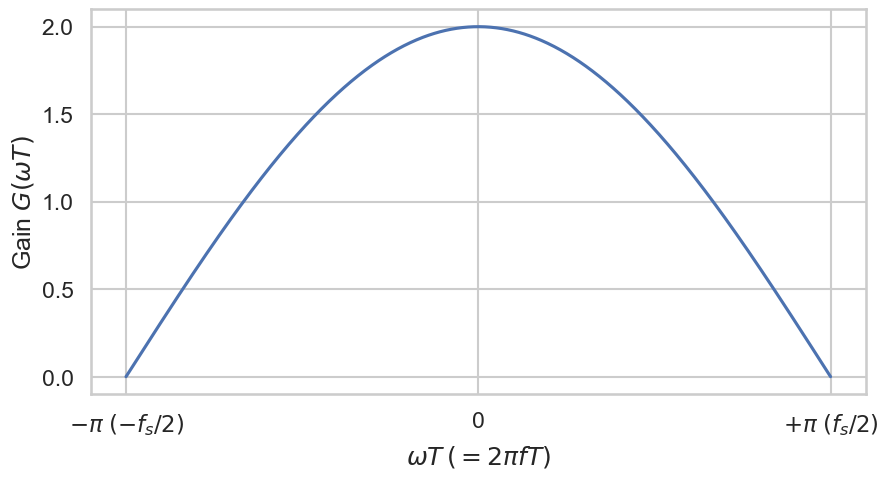

In [3]:
t = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x: 2 * np.cos(x/2)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, gain(t), label=r'$y(t)$')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$ $(-f_s/2)$', r'0', r'$+\pi$ $(f_s/2)$'])
ax.set_ylabel(r'Gain $G(\omega T)$')
ax.set_xlabel(r'$\omega T\,(=2\pi f T)$');

Secondly we look at the *phase response*

$$\mathcal{\Theta}(\omega T) = -\frac{\omega T}{2}, \quad -\pi \leq \omega T < \pi.$$

The plot looks like the following figure.

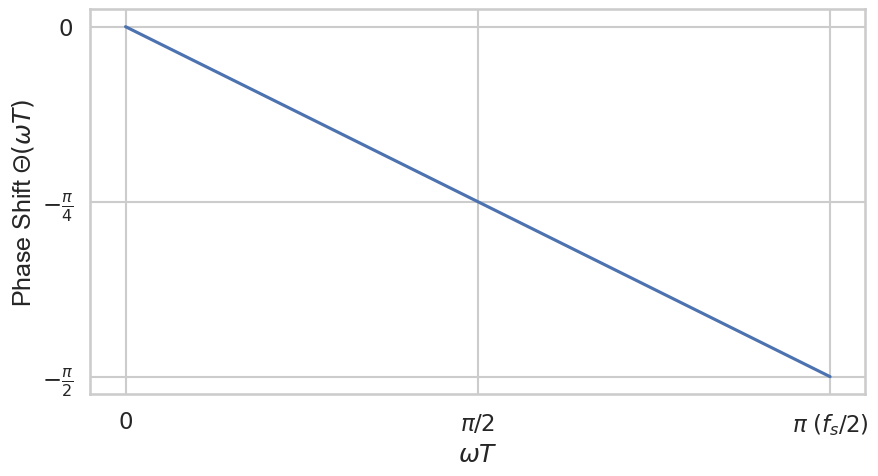

In [4]:
t = np.linspace(0, np.pi, 1000)
phase = lambda x: -x/2

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, phase(t), label=r'$y(t)$')
ax.set_xticks([0, np.pi/2, np.pi])
ax.set_yticks([-np.pi/2, -np.pi/4, 0])
ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$ $(f_s/2)$']);
ax.set_yticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$']);
ax.set_ylabel(r'Phase Shift $\mathcal{\Theta}(\omega T)$')
ax.set_xlabel(r'$\omega T$');

This *lowpass filter* has no phase delay at 0 Hz and a maximum delay of $-(\pi/2)$ at the Nyquist frequency 

$$\omega T = \pi \iff \omega f_s^{-1} = \pi \iff \omega = \pi f_s \iff 2\pi f = \pi f_s \iff f = f_s / 2.$$

**Note that both responses rely on the sample period** $T = 1 / f_s$.
If we increase the sample rate, the loss in power of high frequencies decreases!
To achieve a similar result, we have to adapt the coefficients of the filter equation accordingly.

```{admonition} Low and High Level Filters
:name: remark-low-level-filter
:class: remark

The [frequency response](def-frequency-response) of low level SuperCollider filters such as [OneZero](https://doc.sccode.org/Classes/OneZero.html), [OnePole](https://doc.sccode.org/Classes/OnePole.html), [FOS](https://doc.sccode.org/Classes/FOS.html), [SOS](https://doc.sccode.org/Classes/SOS.html) rely the sample rate $f_s$.
High level filters such as [LPF](https://doc.sccode.org/Classes/LPF.html) and [HPF](https://doc.sccode.org/Classes/HPF.html) do not!

```

Furthermore, the phase shift depends on $\omega$.
It looks like this might lead to a phase distortion, however, this frequency-dependent delay is counteracted because doubling the frequency of the input halves its period, balancing the growth in retardation introduced by the filter.
This linear dependence is actually necessary.

```{admonition} Linear Phase Filters
:name: def-linear-phase-filter
:class: definition

If the phase response of the filter is a linear (straight-line) function of frequency (excluding phase wraps at $\pm 180$ degree), the filter is said to be *linear phase*.

```

Filters that are not linear phase can introduce *phase distortion*.

```{admonition} General Form of a LTI Filter
:name: def-form-lti-filter
:class: definition

An LTI filter may be expressed in general as follows:

\begin{equation}
\begin{split}
y[n] &= \text{Transfer function} \cdot \text{Circular motion}\\
&= G(\omega T) \cdot e^{i \mathcal{\Theta}(\omega T)} \cdot A \cdot e^{i \omega n T + \phi}\\
&= G(\omega T) A \cdot e^{i(\omega n T + \Theta(\omega) + \phi)}
\end{split}
\end{equation}

```

Thus, a filter can be characterized as circular motion with radius $G(\omega T) A$ and phase $\Theta(\omega T)+\phi$.
The particular kind of filter implemented depends only on the definition of $G(\omega T)$ and $\Theta(\omega T)$.

(sec-one-zero-analysis)=
## One Zero Filter

In SuperCollider the *one zero filter* [OneZero](https://doc.sccode.org/Classes/OneZero.html) realizes the following formula:

$$y[n] = (1 - |\alpha|) \cdot x[n] + \alpha \cdot x[n-1], \quad -1 \leq \alpha \leq 1$$

we have $N = 0$ and $M = 1, a_0 = 1, b_0 = (1 - |\alpha|), b_1 = \alpha$.
We can use the [transfer function](sec-trensfer-function) of [LTI filters](def-form-lti-filter) to analyse the effects of the filter.
Using the Z-transform, we get

$$\mathcal{Z}\{ y[n] \} = \frac{(1 - |\alpha|) + \alpha \cdot z^{-1}}{1} = 1 - |\alpha| + \alpha \cdot z^{-1} = H(z).$$

There is a *pole* at $z = \infty$ and a *zero* at $z = \frac{\alpha}{|\alpha|-1}$.
Therefore,

$$H(z) = (1 - |\alpha|) \cdot \left(1 - \frac{\alpha}{|\alpha|-1} z^{-1}\right)$$

If we evaluate the [transfer function](theorem-transfer-function) $H(z)$ for $\alpha = 0.5$ at the frequncies of interest we get the [frequency response](def-frequency-response):

$$H(e^{i \omega T}) = 0.5 \cdot (1 + e^{-i\omega T})$$

which is similar result we got in the last section!

Let us plot the *gain* in frequency for $T = 1$ and different $\alpha$:

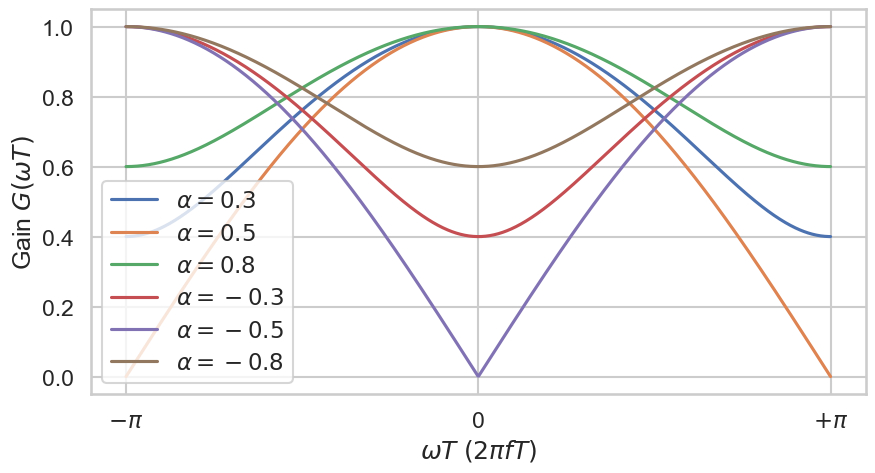

In [5]:
t = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x, alpha: (1-np.abs(alpha)) * (1-(alpha/(np.abs(alpha) -1))*np.exp(-1j*x))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, np.abs(gain(t, 0.3)), label=r'$\alpha = 0.3$')
ax.plot(t, np.abs(gain(t, 0.5)), label=r'$\alpha = 0.5$')
ax.plot(t, np.abs(gain(t, 0.8)), label=r'$\alpha = 0.8$')
ax.plot(t, np.abs(gain(t, -0.3)), label=r'$\alpha = -0.3$')
ax.plot(t, np.abs(gain(t, -0.5)), label=r'$\alpha = -0.5$')
ax.plot(t, np.abs(gain(t, -0.8)), label=r'$\alpha = -0.8$')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', r'0', r'$+\pi$']);
ax.set_ylabel(r"Gain $G(\omega T)$")
ax.set_xlabel(r'$\omega T$ $(2\pi f T)$')
ax.legend();

The unit generator [OneZero](http://doc.sccode.org/Classes/OneZero.html) got his name by the fact that it has **one zero**.

Remember that the filter completely filters $f_s/2$.
But since $f_s = 44100$ the overall effect of the filter hardly audible.
Without a *pole* the filtering effect is weak.
This can be illustrated by using $T = 1/f_s$ with $f_s = 44 100$ for the plot combined with a log-scale:

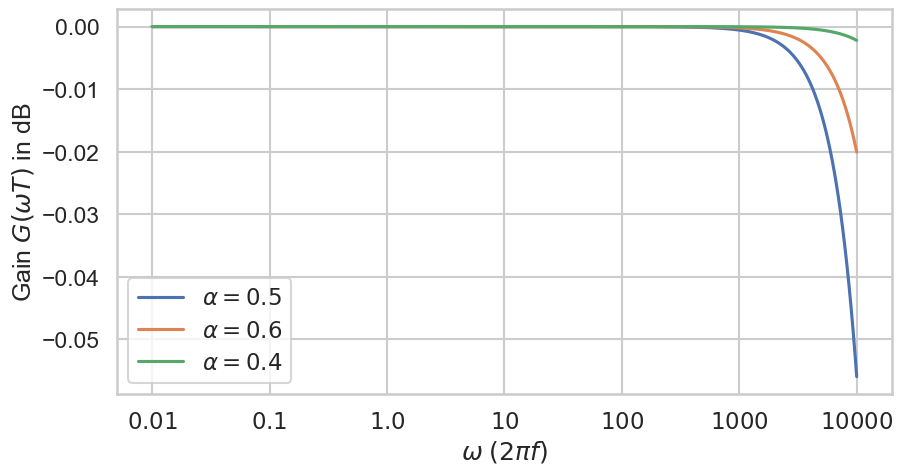

In [6]:
t = np.logspace(start=-2, stop=4, base=10, num=1000)
f_s = 44_100
T = 1.0 / f_s
gain = lambda x, alpha: np.abs((1-np.abs(alpha)) * (1-(alpha/(np.abs(alpha) -1))*np.exp(-1j*x*T)))
#gain = lambda x, alpha: (1-np.abs(alpha)) / np.sqrt((1 - alpha * np.cos(x * T))**2.0 + (alpha * np.sin(x * T))**2.0)
db = lambda x, alpha: 20 * np.log10(gain(x, alpha))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, db(t, 0.5), label=r'$\alpha = 0.5$')
ax.plot(t, db(t, 0.1), label=r'$\alpha = 0.6$')
ax.plot(t, db(t, 0.99), label=r'$\alpha = 0.4$')
#ax.plot(t, db(t, 0.8), label=r'$\alpha = 0.8$')
#ax.plot(t, db(t, -0.5), label=r'$\alpha = -0.5$')
#ax.plot(t, db(t, -0.8), label=r'$\alpha = -0.8$')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1, 10, 100, 1000, 10000])
ax.set_xticklabels([r'$0.01$', r'$0.1$', r'$1.0$', r'$10$', r'$100$', r'$1000$', r'$10000$'])
ax.set_ylabel(r"Gain $G(\omega T)$ in dB")
ax.set_xlabel(r'$\omega$ $(2\pi f)$')
ax.legend();

```isc
(
{ WhiteNoise.ar(0.3!2) }.play;
)
```

In [7]:
import IPython.display as ipd
audio_path = '../../../sounds/white-noise.mp3'
ipd.Audio(audio_path)

```isc
(
{
  var alpha = 0.95;
  OneZero.ar(WhiteNoise.ar(0.3!2), alpha);
}.play;
)
```

In [8]:
import IPython.display as ipd
audio_path = '../../../sounds/onezero-whitenoise.mp3'
ipd.Audio(audio_path)

(sec-one-pole-analysis)=
## One Pole Filter

In SuperCollider the *one pole filter* [OnePole](https://doc.sccode.org/Classes/OnePole.html) realizes the following formula:

$$y[n] - \alpha \cdot y[n-1] = (1 - |\alpha|) \cdot x[n], \quad -1 \leq \alpha \leq 1$$

we have $N = 1$ and $M = 0, a_0 = 1, a_1 = -\alpha, b_0 = (1 - |\alpha|)$
Therefore,

$$\mathcal{Z}\{ y[n] \} = \frac{(1 - |\alpha|)}{1 - \alpha z^{-1}} = H(z).$$

There is a *pole* at $z = \alpha$ and a *zero* at $z = \infty$.
Therefore,

$$H(z) = \frac{(1 - |\alpha|)}{1 - \alpha z^{-1}}.$$

If we evaluate $H(z)$ for $\alpha = 0.5$ at the frequncies of interest we can see the *frequency response*:

$$H(e^{i \omega T}) = \frac{0.5}{1 - 0.5 e^{-i \omega T}} = \frac{1}{2 - e^{-i \omega T}}.$$

Let us plot the *gain* in frequency for $T = 1$ and different $\alpha$:

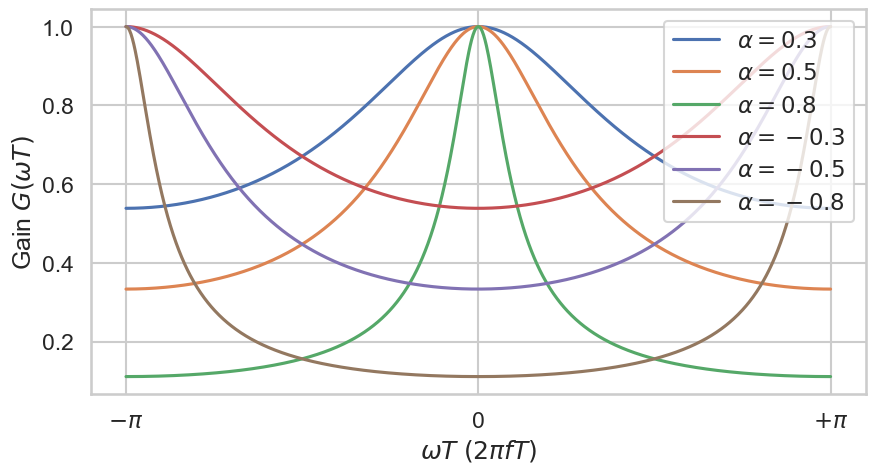

In [9]:
t = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x, alpha: (1-np.abs(alpha)) / (1-alpha*np.exp(-1j*x))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, np.abs(gain(t, 0.3)), label=r'$\alpha = 0.3$')
ax.plot(t, np.abs(gain(t, 0.5)), label=r'$\alpha = 0.5$')
ax.plot(t, np.abs(gain(t, 0.8)), label=r'$\alpha = 0.8$')
ax.plot(t, np.abs(gain(t, -0.3)), label=r'$\alpha = -0.3$')
ax.plot(t, np.abs(gain(t, -0.5)), label=r'$\alpha = -0.5$')
ax.plot(t, np.abs(gain(t, -0.8)), label=r'$\alpha = -0.8$')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', r'0', r'$+\pi$']);
ax.set_ylabel(r'Gain $G(\omega T)$')
ax.set_xlabel(r'$\omega T$ $(2\pi f T)$')
ax.legend();

This explains the name of the unit generator [OnePole](http://doc.sccode.org/Classes/OneZero.html).
It got his name by the fact that it has **one pole**.
Compared to the *one zero filter* it is able to have a much steeper drop / increase in *gain*.
Similar to the *one zero filter* it is a low pass filter for positive $\alpha$ and high pass filter for negative $\alpha$.
For both these filters, the cutoff frequency $f_c$ is equal to 0 Hz, i.e., all frequencies are effected.

If we use a sample frequency $f_s = 44 100$ Hz, then we get the following realistic result below.
As you can see, we have to choose $\alpha$ close to $1.0$ to achieve a drop in gain across audible frequencies.

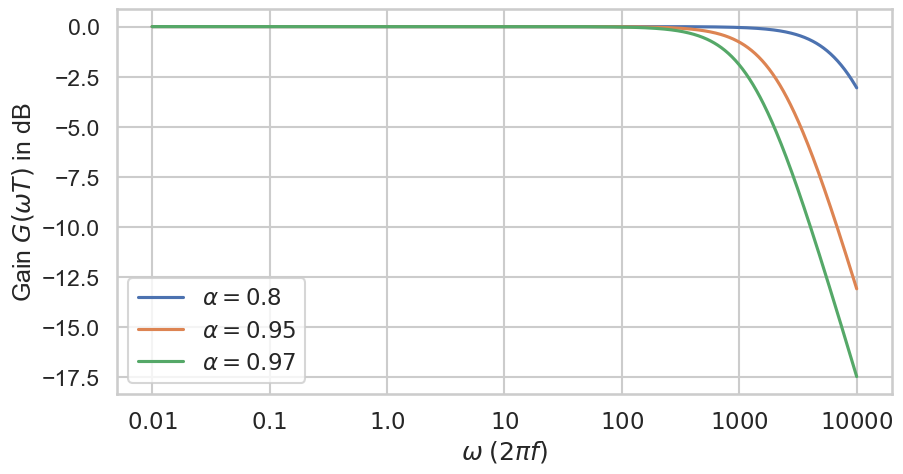

In [10]:
t = np.logspace(start=-2, stop=4, base=10, num=1000)
f_s = 44_100
T = 1.0 / f_s
gain = lambda x, alpha: np.abs((1-np.abs(alpha)) / (1-alpha*np.exp(-1j*x*T)))
#gain = lambda x, alpha: (1-np.abs(alpha)) / np.sqrt((1 - alpha * np.cos(x * T))**2.0 + (alpha * np.sin(x * T))**2.0)
db = lambda x, alpha: 20 * np.log10(gain(x, alpha))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, db(t, 0.8), label=r'$\alpha = 0.8$')
ax.plot(t, db(t, 0.95), label=r'$\alpha = 0.95$')
ax.plot(t, db(t, 0.97), label=r'$\alpha = 0.97$')
#ax.plot(t, db(t, 0.8), label=r'$\alpha = 0.8$')
#ax.plot(t, db(t, -0.5), label=r'$\alpha = -0.5$')
#ax.plot(t, db(t, -0.8), label=r'$\alpha = -0.8$')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1, 10, 100, 1000, 10000])
ax.set_xticklabels([r'$0.01$', r'$0.1$', r'$1.0$', r'$10$', r'$100$', r'$1000$', r'$10000$'])
ax.set_ylabel(r"Gain $G(\omega T)$ in dB")
ax.set_xlabel(r'$\omega$ $(2\pi f)$')
ax.legend();

```isc
(
{ WhiteNoise.ar(0.3!2) }.play;
)
```

In [11]:
import IPython.display as ipd
audio_path = '../../../sounds/white-noise.mp3'
ipd.Audio(audio_path)

```isc
(
{
  var alpha = 0.95;
  OnePole.ar(WhiteNoise.ar(0.3!2), alpha);
}.play;
)
```

In [12]:
audio_path = '../../../sounds/onepole-whitenoise.mp3'
ipd.Audio(audio_path)

## Butterworth Filter

The default *low-* and *highpass filters* unit generators (``LPF`` and  ``HPF`` respectively) of ``sclang``, filter frequencies above or below some *cutoff frequency*.
They are *2nd order Butterworth low-/highpass filter*.
The gain $G(\omega)$ of the a $n$-order **analog** Butterworth low-/highpass filter is defined by:

$$G(\omega) = |H(i \omega)| = \frac{1}{\sqrt{1+ (\omega)^{2n}}}.$$

Note that we are currently looking at an anlalog signal thus we do not use $H(e^{i \omega T})$ but $H(i \omega)$.
The *[frequency response](def-frequency-response)* of a *2nd order **analog** Butterworth lowpass filter* is illustrated below.
$n$ is the order as well as the number of *poles* of the filter.
The filter reduces the gain (amplitude) for frequencies above the cutoff frequency and shifts their phases.
Well, that is not entirely true because the cutoff frequency is also reduced by 6 [decibel (dB)](sec-intensity), so the reduction starts a little bit below the cutoff frequency.
Reducing the loudness by 6 dB means that the perceived level is reduced by a factor of 4.
The top plot of shows the reduction in amplitude.

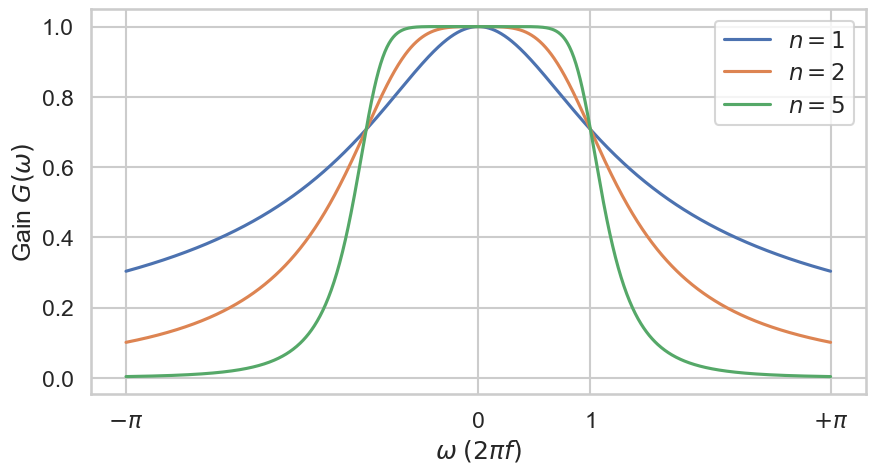

In [13]:
omega = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x, n: 1 / (np.sqrt(1+np.power(x, 2*n)))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(omega, np.abs(gain(omega, 1)), label=r'$n = 1$')
ax.plot(omega, np.abs(gain(omega, 2)), label=r'$n = 2$')
ax.plot(omega, np.abs(gain(omega, 5)), label=r'$n = 5$')
ax.set_xticks([-np.pi, 0, 1.0, np.pi])
ax.set_xticklabels([r'$-\pi$', r'0', r'1', r'$+\pi$']);
ax.set_ylabel(r'Gain $G(\omega)$')
ax.set_xlabel(r'$\omega$ $(2\pi f)$')
ax.legend();

If $\omega_c$ is the cutoff frequency and $G_0$ is the DC gain (gain at zero frequency), than the gain is

$$G(\omega) = \frac{G_0}{\sqrt{1+ \left(\frac{i\omega}{i \omega_c} \right)^{2n}}}.$$

Thus the plot above illustrates the gain for a cutoff frequency $\omega_c=1$.
We can change the scaling of our axis to display gain in decible and to reflect the exponential character of frequencies.

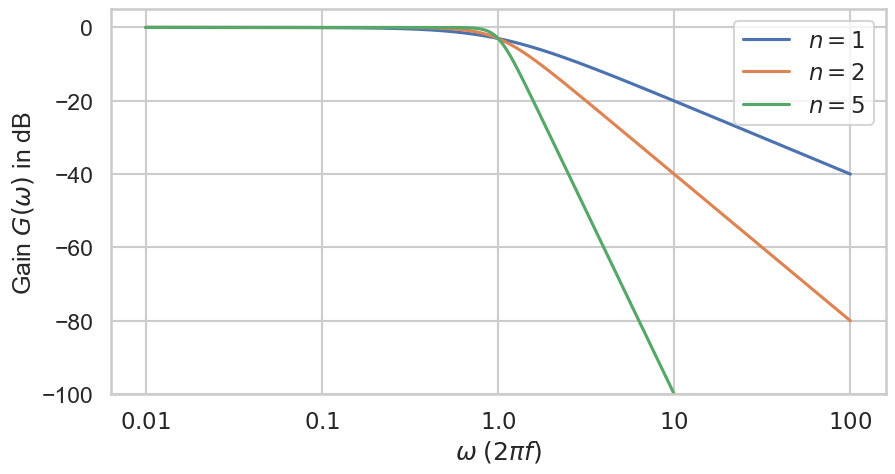

In [14]:
omega = np.logspace(start=-2, stop=2, base=10, num=1000)
gain = lambda x, n: 1 / (np.sqrt(1+np.power(x, 2*n)))
db = lambda x, n: 20 * np.log10(gain(x, n))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(omega, db(omega, 1), label=r'$n = 1$')
ax.plot(omega, db(omega, 2), label=r'$n = 2$')
ax.plot(omega, db(omega, 5), label=r'$n = 5$')
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1, 10, 100])
ax.set_xticklabels([r'$0.01$', r'$0.1$', r'$1.0$', r'$10$', r'$100$'])
ax.set_ylabel(r'Gain $G(\omega)$ in dB')
ax.set_xlabel(r'$\omega$ $(2\pi f)$')
ax.set_ylim(-100, 5)
ax.legend();

The second effect of the filter is a phase shift.
This effect is crucial if we combine multiple filters because they interact!
In other words: we can not just combine a high pass and lowpass filter to get the same result as a band pass filter!

To convert the digitalize the analog filter we can apply the so called *[bilinear transform](https://en.wikipedia.org/wiki/Bilinear_transform)*.
It is a first oder Padé approximant of the natural logarithm function that is an exact mapping of the $z$-plane to the $s$-plane, where $s := i \omega$.
When the Laplace transform is performed on a discrete-time signal (with each element of the discrete-time sequence attached to a correspondingly delayed unit impulse), the result is precisely the [Z-transform](sec-z-transform) of the discrete-time sequence with the substitution of

$$z = e^{sT} = e^{i \omega T} = \frac{e^{i \omega T / 2}}{e^{- i \omega T / 2}} \approx \frac{1 + i \omega T / 2}{1 - i \omega T / 2}.$$

The inverse of this mapping (and its first-order bilinear appoximation) is 

$$s = \frac{1}{T} \ln(z) \approx \frac{2}{T} \frac{z-1}{z+1} = \frac{2}{T} \frac{1-z^{-1}}{1+z^{-1}}.$$

Therefore, the **approximated** gain $G(\omega T)$ of the a $n$-order **digital** Butterworth low-/highpass filter is defined by:

$$G(\omega T) \approx \frac{1}{\sqrt{1+ (\frac{2}{T} \frac{e^{i \omega T}-1}{e^{i \omega T}+1})^{2n}}}$$

Plotting this function gives not the same result compared to the analog version.
There is a clear difference.

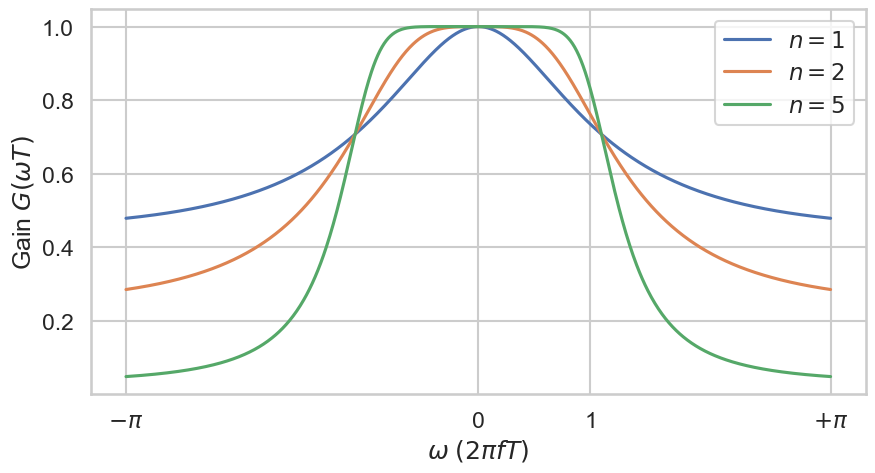

In [15]:
omega = np.linspace(-np.pi, np.pi, 1000)
gain = lambda x, n: 1 / (np.sqrt(1+np.power(2 * (1-np.exp(-x * 1)) / (1+np.exp(-x * 1)), 2*n)))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(omega, np.abs(gain(omega, 1)), label=r'$n = 1$')
ax.plot(omega, np.abs(gain(omega, 2)), label=r'$n = 2$')
ax.plot(omega, np.abs(gain(omega, 5)), label=r'$n = 5$')
ax.set_xticks([-np.pi, 0, 1, np.pi])
ax.set_xticklabels([r'$-\pi$', r'0', r'1', r'$+\pi$']);
ax.set_ylabel(r'Gain $G(\omega T)$')
ax.set_xlabel(r'$\omega$ $(2\pi f T)$')
ax.legend();

```isc
(
{ WhiteNoise.ar(0.3!2) }.play;
)
```

In [16]:
import IPython.display as ipd
audio_path = '../../../sounds/white-noise.mp3'
ipd.Audio(audio_path)

```isc
(
{
  var cutoff = 600;
  LPF.ar(in: WhiteNoise.ar(0.3!2), freq: cutoff);
}.play;
)
```

In [17]:
import IPython.display as ipd
audio_path = '../../../sounds/lpf-whitenoise.mp3'
ipd.Audio(audio_path)

(sec-impulse-response)=
## Impulse Response

Another fundamental result in [LTI](def-linear-time-invariant) system theory is that any LTI system can be characterized entirely by a single function called the system's *impulse response* (in the time domain).
The output of the filter $y[n]$ is given by the [convolution](sec-convolution) of the input of the filter $x[n]$ with the system's *impulse response* $h[n]$, that is,

$$y[n] = (x * h)[n].$$

```{admonition} Impulse Response
:name: def-impulse-response
:class: definition

The *impulse response*, or *impulse response function (IRF)*, of a filter is its output when presented with a brief input signal, called an *impulse* $\delta(t)$.
In the discrete case this the impulse is defined by the [Kronecker $\delta$-function](def-kronecker-delta) $\delta[n]$.

```

The *Dirac delta distribution* ($\delta$ distribution), also known as *unit impulse*, is a generalized function or distribution over the real numbers, whose value is zero everywhere expect at zero, and whose integral over the entire real line is equal to one:

$$\delta(t) = 0 \Rightarrow t \neq 0 \quad \land \quad \int_{-\infty}^\infty \delta(t) dt = 1.$$

Strictly speaking $\delta(t)$ not a function because it is not defined for $\delta(0)$.
One can define

$$\delta(t) = \lim\limits_{b \rightarrow 0} \frac{1}{|b| \sqrt{\pi}} e^{-(x/b)^2}.$$

Interestingly, the Dirac delta function is the neutral element of the [convolution](sec-convolution), that is,

$$(y * \delta) = (\delta * y) = y.$$

In the discrete case, things are more intuitive via the *Kronecker delta function* $\delta[n]$.

```{admonition} Kronecker $\delta$-Function
:name: def-kronecker-delta
:class: definition

The *Kronecker delta function* $\delta : \mathbb{Z} \rightarrow \{0, 1\}$ is defined by 

\begin{equation}
\delta[n] = \begin{cases}
1, & \text{if } n = 0,\\
0, & \text{otherwise}.
\end{cases}
\end{equation}

```

It is the discrete analog of the *Dirac delta function*.
For example, the filter response of our *simple filter* is

$$h[n] = \delta[n] + \delta[n-1], \quad  n = 0, 1, 2, \ldots$$

which gives us $h[0] = h[1] = 1$ and $h[n] = 0$ for all $n \geq 2$.
Note that any signal $x[\cdot]$ can be expressed as a combination of weighted delta functions, i.e.,

$$x[n] = \delta_n[n] \cdot x[n] \text{ with } \delta_n[k] = \delta[k-n].$$

```{admonition} FIR Filter
:name: def-fir-filter
:class: definition

A filter with a finite impulse response, e.g. echos, is called *final impulse response (FIR)* filter.
All filters of the form

\begin{equation}
y[n] = \sum\limits_{k=0}^M b_k x[n-k]
\end{equation}

are *FIR filters*.

```

A [one zero filter](sec-one-zero-analysis) is a FIR filter.
A [one pole filter](sec-one-pole-analysis) is a *infinite impulse response (IIR)* filter since the feedback process will create an endless number of decaying impulses.

```{admonition} IIR Filter
:name: def-iir-filter
:class: definition

A filter with a infinite impulse response, e.g. echo with feedback, is called *infinite impulse response (IIR)* filter.
```

Let's look at the *one pole filter* with $\alpha = 0.5$ for simplification.
We get

$$h[n] = 0.5 \delta[n] + 0.5 h[n-1] = 0.5 \delta[n] + 0.5 h[n-1]$$

whith $h[0] = \delta[0] = 0.5$.
It follows that $h[1] = 0.25$, $h[2] = 0.125$ and in general

$$h[n] = 0.5^{n+1}, \quad n = 0, 1, 2, \ldots$$

In other words the impulse response $h$ converges to zero $\lim_{n \leftarrow \infty} h[n] = 0$ but never reaches it.
If we compute the *discrete-time Fourier transform* of $h[\cdot]$ we should get the frequency resonse $H(e^{i \omega T})$:

$$\sum\limits_{n-=\infty}^\infty h[n] e^{-i \omega n T} = \sum\limits_{n = 0}^\infty 0.5^{n+1} e^{-i \omega n T} = \frac{1}{2-e^{i \omega T}}$$

Note that the last step is non-trivial!